In [117]:
from simulation_functions import index, simulation_, plot
from interpolation_functions import T_K
from make_noise_updated import simulate_noise
import numpy as np
import matplotlib.pyplot as plt
from microlensing import make_microlensing
%matplotlib inline

mic0, mic1, mic2, mic3 = make_microlensing(u0=1.5), make_microlensing(u0=1.4, d= -1500, te= 50),make_microlensing(u0=1.9, d = 500, te = 700),make_microlensing(u0=1.1, d = 1000)
mag0, mag1,mag2,mag3 = mic0[1], mic1[1],mic2[1],mic3[1]

sim = simulate_noise(15) # first argument dt_max: time delay is chosen randomly between 0 and dtmax.
time_delays = sim[2]
ts = sim[0]+np.max(time_delays) # observation time sample (same for all curves= non_shifted)

fs = sim[1]
fsm = np.concatenate([(fs[0]+mag0)[np.newaxis,:],(fs[1]+mag1)[np.newaxis,:],(fs[2]+mag2)[np.newaxis,:],(fs[3]+mag3)[np.newaxis,:]])


f = sim[6]
t = sim[7]

sampling = 3
h=sampling
# desired sampling for each curve


tk = np.linspace(np.min(ts),np.max(ts),np.int(np.abs((np.min(ts)-np.max(ts))/h)),dtype=float,retstep=True)[0]  # [1] gives approx : h


# dt is part of the argument ts+dt -tk of the sinc matrix
dt = np.array([1.,1.,1.,1.])
arg = np.argsort(time_delays)[::-1] # in index terms: from highest time delay to lowest
dt[arg[0]] = 0 #curve with highest time delay has dt = 0
#in what comes: curve with ith highest time delay has :dt = max time delay- ith highest time delay
dt[arg[1]] = np.max(time_delays)-time_delays[arg[1]]
dt[arg[2]] = np.max(time_delays)-time_delays[arg[2]]
dt[arg[3]] = np.max(time_delays)-time_delays[arg[3]]

#print('k = ', len(tk),'\ns = ', len(ts))
matrix = []
for i in range(4):
    matrix.append(np.array([(ts[:,np.newaxis])-dt[i]-tk[np.newaxis,:]])) # change time_delays to dt #
matrix = np.array(matrix)

A = np.sinc(np.concatenate([matrix[0],matrix[1],matrix[2],matrix[3]],axis =0)/h) # 4 x s x K  , add h* to try

Y= np.concatenate([fsm[0][np.newaxis,:],fsm[1][np.newaxis,:],fsm[2][np.newaxis,:],fsm[3][np.newaxis,:]]) # 4 x s
#print('A.shape: ', A.shape, '\nY.shape: ', Y.shape)

In [118]:
mic_mag = np.concatenate([mag0[np.newaxis,:], mag1[np.newaxis,:],mag2[np.newaxis,:],mag3[np.newaxis,:]])

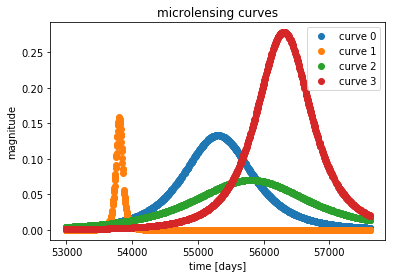

In [54]:
for i in range(4):
    plt.plot(mic0[0],mic_mag[i],'o', label = "curve "+ str(i))

plt.legend()
plt.xlabel('time [days]')
plt.ylabel('magnitude')
plt.title('microlensing curves')
plt.savefig('figures/microlensing')
plt.show()

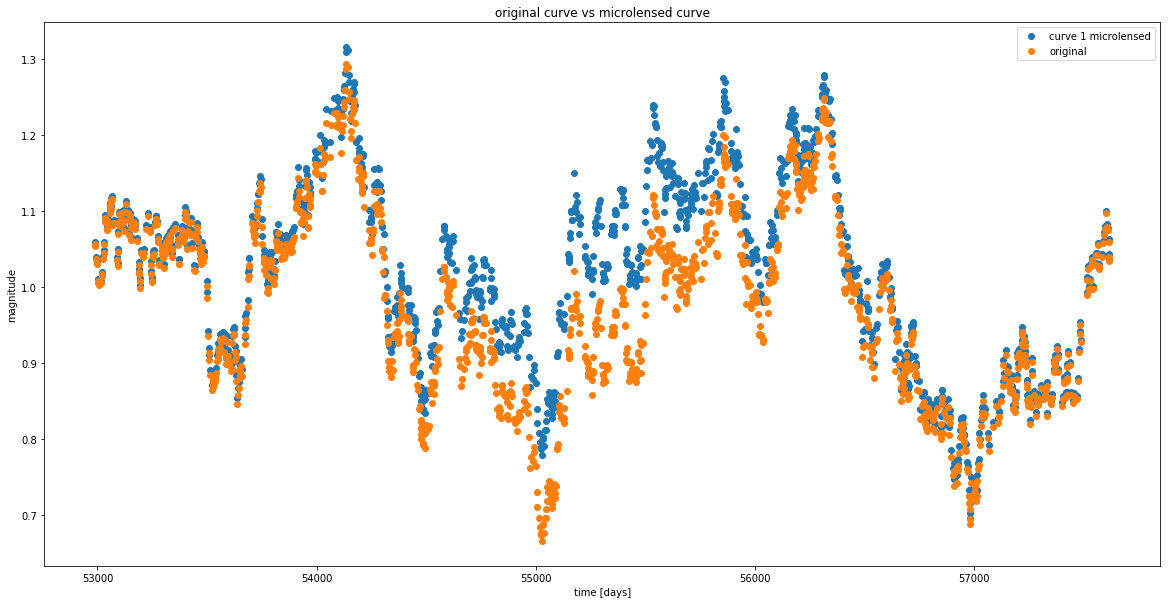

In [158]:
plt.figure(figsize=(20,10))
plt.plot(sim[0], fsm[0],'o', label = 'curve 1 microlensed')
plt.plot(sim[0], fs[0],'o', label = 'original')
plt.title('original curve vs microlensed curve')
plt.legend()
plt.xlabel('time [days]')
plt.ylabel('magnitude')
plt.show()

In [56]:
# plt.plot(sim[0], fs[0],'o')
# plt.plot(sim[0], fs[1]+0.1,'o')
# plt.plot(sim[0], fs[2]+0.3,'o')
# plt.plot(sim[0], fs[3]+0.5,'o')
# plt.show()

In [119]:
# multiplication functions:
noise_std = sim[3]
def AT(X,A,Y, M0,M1,M2,M3): 
    '''
    calculateS the weighted mean of A.T(Y-AX)
    input:
    X : array with shape k, solution of interpolation
    A : tensor of shape 4xsxk, sinc matrix
    Y : matrix of shape 4xs, magnitudes of original time sampling
    '''
    
    M = np.zeros((4, len(tk)))
    M[0],M[1],M[2],M[3] = M0,M1,M2,M3
    sum_ = 0
    for i in range(4):
        sum_ += np.dot(A[i].T, Y[i] - A[i] @ X - A[i] @ M[i])#*((1/noise_std[i])**2)
    
    return sum_#/np.sum(1/(noise_std**2))

def multiplication(X,S): # X.S
    '''
    multiplies X by S[i] and takes the arithmetic mean
    '''
    this =[]
    for i in range(4):
        this.append(np.dot(X,S[i]))
    this = np.array(this)
    return np.mean(this,axis=0)

def multiplication_T(X,S): # X.S.T

    '''
    multiplies X by S[i].T and take the arithmetic mean
    '''
    this =[]
    for i in range(4):
        this.append(np.dot(X,S[i].T))
    this = np.array(this)
    return np.mean(this,axis=0)

def residuals(Y,A,X,M):
    sum = 0
    for i in range(4):
        sum += ((Y-A@X-A@M[i])**2)
    return np.sum(sum)

In [196]:
def linorm(S, nit):
    x0 = np.random.rand(S.shape[1])  # chose [1] per the implementation of the power iteration method in wiki
    x0 = x0 /np.linalg.norm(x0)
    for i in range(nit):
        x = multiplication(x0,S)#np.dot(x0,S)
        xn = np.linalg.norm(x)
        xp = x / xn#     
        y = multiplication_T(xp,S) # the S.T is done within the functionas S[i].T not S.T[i]
        yn = np.linalg.norm(y)  
        x0 = y / yn
    return 1./xn
mu = linorm(A,20)/170 # = 0.0038

X = np.zeros(len(tk))
M = np.zeros((4,len(tk)))
M_new = np.zeros((4,len(tk)))


count = 0
R = [np.sum(Y ** 2)]
epsilon = 0.3

S_var_M = np.zeros((4,len(tk)-1))



In [197]:
# max_ = []
# for i in range(4):
#     max_.append(np.max((fs[i][1:]-fs[i][:-1])))#/((ts-dt[i])[1:]-(ts-dt[i])[:-1])))

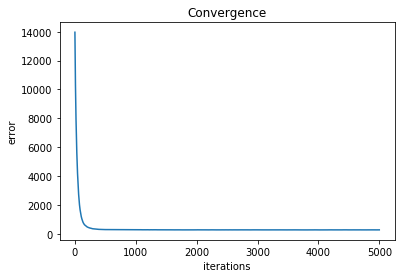

In [198]:
max_var = np.abs(np.max((f[1:]-f[:-1])))#/(t[1:]-t[:-1]))) # exact if without noise (f doesnt have noise)
# with total variation
while (R[-1] > epsilon) and (
        count < 5000):  # 5000 is a good amount of counts
    X_new = X + mu * AT(X,A,Y,M[0],M[1],M[2],M[3])
    X = X_new.copy()  
    
    X[X<0] = 0

    S_var = (X[:-1]-X[1:])#/((tk[:-1]-tk[1:]))
    sign = np.sign(S_var[np.abs(S_var) >2*max_var])
    loc = np.where(np.abs(S_var) >2*max_var)
    X[loc] = X[loc] - 2*max_var*sign
        
    
    M = np.concatenate([M0[np.newaxis,:], M1[np.newaxis,:],M2[np.newaxis,:],M3[np.newaxis,:]])
    
    for i in range(4):
        M_new[i] = M[i] + mu*np.dot(A[0].T, Y[0] - A[0] @ X- A[0] @ M[i])
        M[i] = M_new[i].copy()
        
    
        S_var_M[i] = ((M[i])[:-1]-(M[i])[1:])#/((tk[:-1]-tk[1:]))
        sign = np.sign(S_var_M[i][np.abs(S_var_M[i]) >5*max_var])
        loc = np.where(np.abs(S_var_M[i]) >5*max_var)
        M[i][loc] = M[i][loc] - 3*max_var*sign
       
        M[i][M[i]<0] = 0



    R.append(residuals(Y,A,X,M))   #(np.sum((Y - A @ X- A@M) ** 2.))
    count += 1


plt.title('Convergence')
plt.plot(np.array(R[1:]))
plt.xlabel('iterations')
plt.ylabel('error')
plt.show()

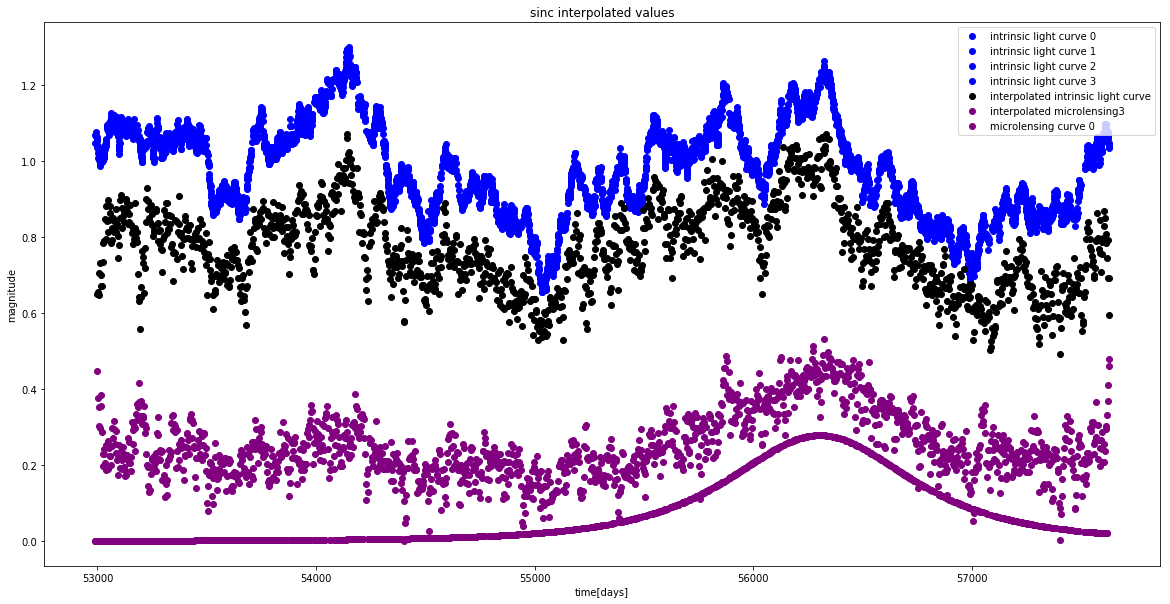

In [200]:
%matplotlib inline
cut = np.logical_and(X < np.max(Y), X > np.min(Y))
plt.figure(figsize=(20,10))

# for i in range(4):
#     plt.plot(ts-dt[i], Y[i], 'o', label='microlensed light curve '+str(i))    


    
for i in range(4):
    plt.plot(ts-dt[i], fs[i], 'o', label='intrinsic light curve '+str(i), color = 'blue')    

plt.plot(tk, X,'o', label='interpolated intrinsic light curve', color='black')
# plt.plot(tk, M0,'o', label='interpolated microlensing0',color = 'r')
# plt.plot(tk, M1,'o', label='interpolated microlensing1', color = 'g')
# plt.plot(tk, M2,'o', label='interpolated microlensing2', color = 'pink')
plt.plot(tk, M3,'o', label='interpolated microlensing3', color = 'purple')



# plt.plot(mic0[0],mic_mag[0],'o', label = "microlensing curve 0", color = 'r')
# plt.plot(mic0[0],mic_mag[1],'o', label = "microlensing curve 0", color = 'g')
# plt.plot(mic0[0],mic_mag[2],'o', label = "microlensing curve 0", color = 'pink')
plt.plot(mic0[0],mic_mag[3],'o', label = "microlensing curve 0", color = 'purple')


#plt.plot(tk, X,'o', label='interpolated', color='black')
#plt.plot(t,f,'o', label = 'true')
plt.xlabel('time[days]')
plt.ylabel('magnitude')
plt.title('sinc interpolated values')
plt.legend()
#plt.savefig("pos2 and total variation1 on X and M 5,5,3.png")
plt.show()

wondering about: (to discuss in meeting)
- multiplication_T(X,S): X,S[i].T versus X,S.T[i]
- ts-dt[i] is just t_drive+max(time delay)- max(time delay) + time delay = t_drive + time delay
- scaling with the time gap does not work out, the scatter gets larger or it diverges.  I might be doing it wrong?

In [136]:
fsm.flatten().shape

(5476,)

In [137]:
ts.shape

(1369,)